# Airbnb NYC Price Prediction

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import skew, boxcox
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/Drago/Desktop/AB_NYC_2019.csv')

In [3]:
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
df.isnull().sum().sort_values(ascending=False)

reviews_per_month                 10052
last_review                       10052
host_name                            21
name                                 16
availability_365                      0
calculated_host_listings_count        0
number_of_reviews                     0
minimum_nights                        0
price                                 0
room_type                             0
longitude                             0
latitude                              0
neighbourhood                         0
neighbourhood_group                   0
host_id                               0
id                                    0
dtype: int64

- Some features are missing. These features will be handled later

In [6]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

## EDA

### The relationship between room type & price

Text(0.5, 1.0, 'Room Type VS Price')

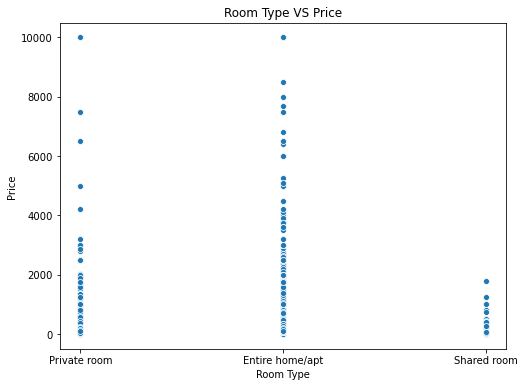

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='room_type', y='price', data=df)
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.title('Room Type VS Price')

- Shared room is lower than 2000, but some of private room and entire home contain some expensinve price

### The relationship between room type & Price base on the different neighborhood group

Text(0.5, 1.0, 'Room Type VS Price VS Neighborhood Group')

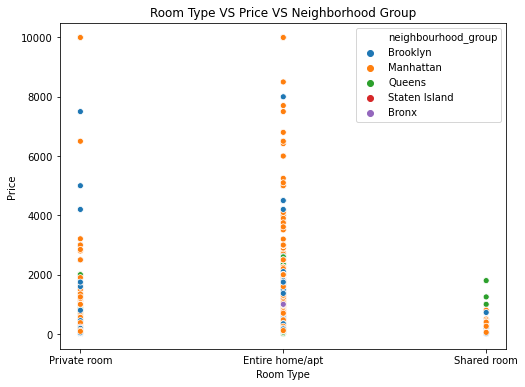

In [8]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='room_type', y='price',hue='neighbourhood_group' ,data=df)
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.title('Room Type VS Price VS Neighborhood Group')

- Both private room and entire home in Manhattan and Brooklyn
- Queen has the highest price for the shared room

### The relationship between Price and Number of Reviews based on the neighborhood group

Text(0.5, 1.0, 'Price VS Number of Reviews VS Neighborhood Group')

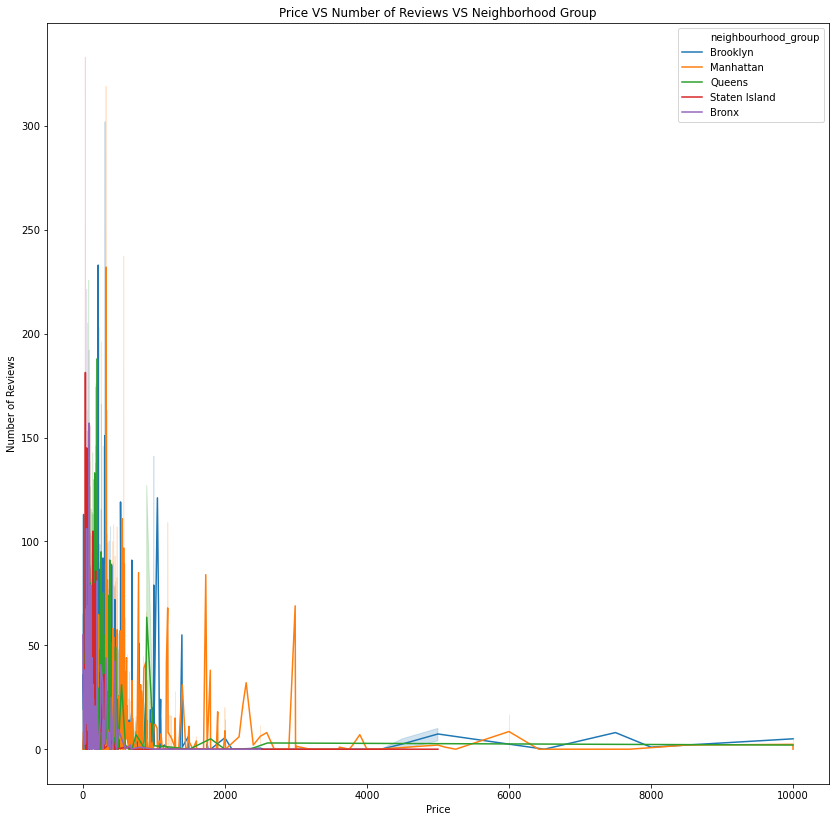

In [9]:
plt.figure(figsize=(14,14))
sns.lineplot(x='price', y='number_of_reviews',hue='neighbourhood_group' ,data=df)
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.title('Price VS Number of Reviews VS Neighborhood Group')

- Negative relationship between Price and Number of Reviews: Low Price range rooms have more reviews than the high price range rooms
- Manhattan, Queens, and Brooklyn have more number of reviews in a high price range rooms than others

### Minimum nights based on room types

Text(0.5, 1.0, 'Minimum Nights based on room types')

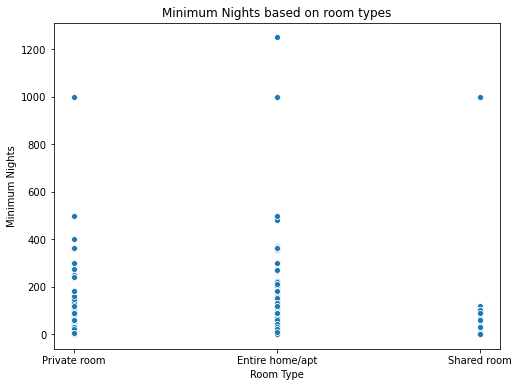

In [10]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='room_type', y='minimum_nights', data=df)
plt.xlabel('Room Type')
plt.ylabel('Minimum Nights')
plt.title('Minimum Nights based on room types')

- Shared rooms require less than 200 days for a minimum stay
- Some of Private rooms and Entire homes require between 200-400 days for a minimum stay. Few of thems require around 1000 days

### Price Distribution

Text(0.5, 1.0, 'Price Distribution Plot')

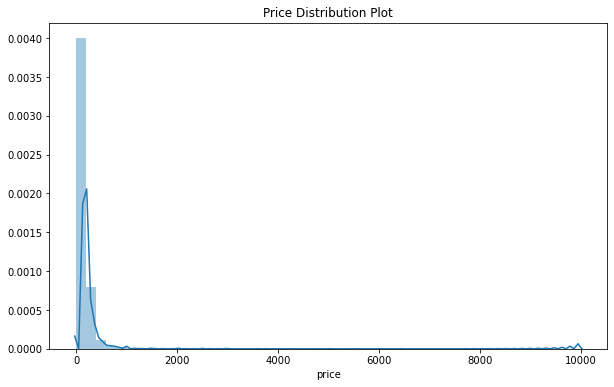

In [11]:
plt.figure(figsize=(10,6))
sns.distplot(df['price'], norm_hist=True)
plt.title('Price Distribution Plot')

- Positive skewness on price
- Apply Log transformation to make price distribution less skewed

### Relationship with numerical variables

In [12]:
numeric_col = df.drop(['id','host_id'],axis=1)
numeric_col = numeric_col.select_dtypes(include=['int64'])
numeric_col.dtypes

price                             int64
minimum_nights                    int64
number_of_reviews                 int64
calculated_host_listings_count    int64
availability_365                  int64
dtype: object

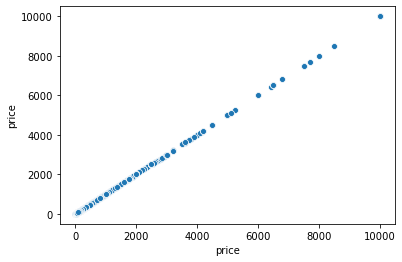

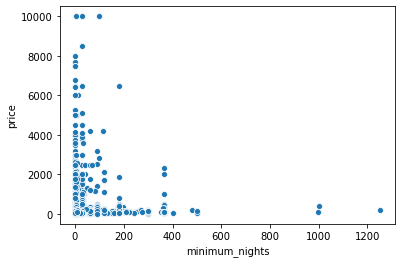

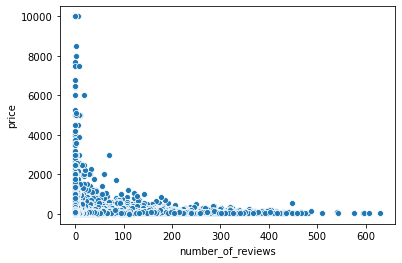

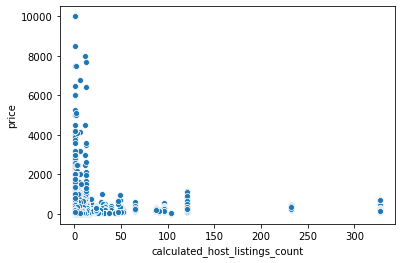

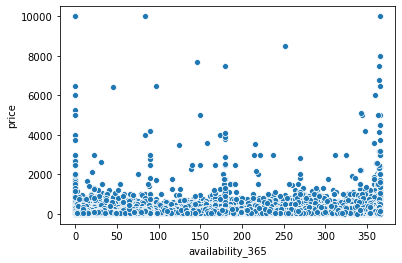

<Figure size 432x432 with 0 Axes>

In [13]:
for i, col in enumerate(numeric_col.columns):    
    plt.figure(i)
    sns.scatterplot(x=col, y='price',data=numeric_col)
plt.figure(figsize=(6,6))
plt.show()

- All the numerical features are non-linear
- This problem will be handled later

### Using Log Transformation on Price

- Purpose of transformationt technique: stabilize variance, make the data more normal distribution-like, improve the validity of measures of association

In [14]:
skewness = skew(numeric_col)

In [15]:
skewness = pd.DataFrame({'Skewness': skewness}, index=['price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365'])
skewness

,Skewness
price,19.118352
minimum_nights,21.826605
number_of_reviews,3.690521
calculated_host_listings_count,7.932931
availability_365,0.763384


In [16]:
# Adding Log Price Column
df['price_log'] = np.log(df.price+1)

Text(0.5, 1.0, 'Log Price Distribution Plot')

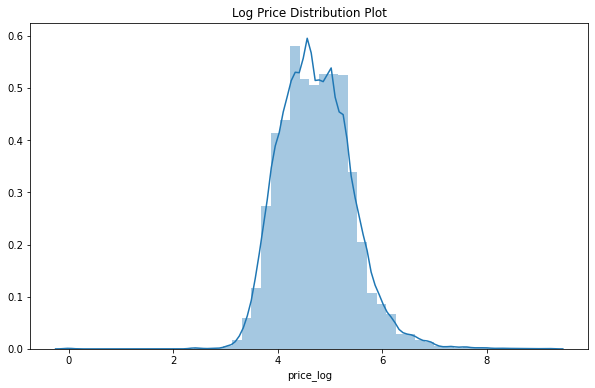

In [17]:
plt.figure(figsize=(10,6))
sns.distplot(df['price_log'])
plt.title('Log Price Distribution Plot')

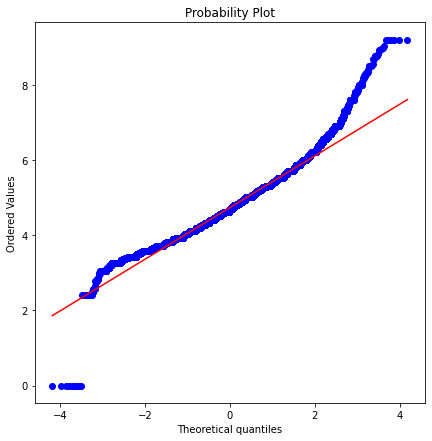

In [18]:
plt.figure(figsize=(7,7))
stats.probplot(df['price_log'],plot=plt)
plt.show()

In [19]:
df_new = df.drop(columns=['id','name','host_id','host_name','last_review','price','neighbourhood'])

In [20]:
df_new.isnull().sum().sort_values(ascending=False)

reviews_per_month                 10052
price_log                             0
availability_365                      0
calculated_host_listings_count        0
number_of_reviews                     0
minimum_nights                        0
room_type                             0
longitude                             0
latitude                              0
neighbourhood_group                   0
dtype: int64

In [21]:
mean = df_new['reviews_per_month'].mean()
df_new['reviews_per_month'].fillna(mean, inplace=True)
df_new.isnull().sum()

neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
price_log                         0
dtype: int64

### Correlation Matrix

In [22]:
numeric_col_new = df_new.select_dtypes(exclude = ['object'])

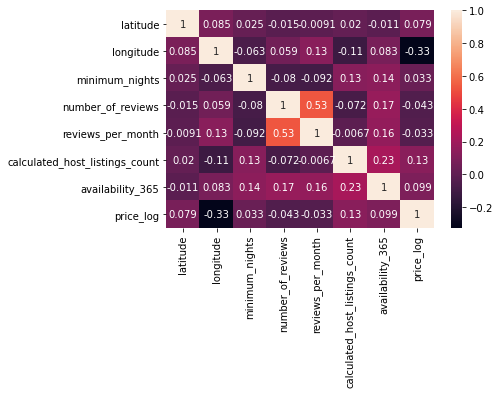

In [23]:
sns.heatmap(numeric_col_new.corr(method='pearson'),annot=True)

### One-hot Encoding

In [24]:
cat_col = df_new.select_dtypes(include=['object'])

In [25]:
dummy = pd.get_dummies(cat_col)

In [26]:
df_new = pd.concat([numeric_col_new, dummy],axis=1)

In [27]:
df_new = df_new.rename({'neighbourhood_group_Bronx':'Bronx', 
                       'neighbourhood_group_Brooklyn':'Brooklyn','neighbourhood_group_Manhattan':'Manhatttan'
                       ,'neighbourhood_group_Queens':'Queens','neighbourhood_group_Staten Island':'Staten Island',
                       'room_type_Entire home/apt':'Entire home/apt','room_type_Private room':'Private room',
                        'room_type_Shared room':'Shared room'},axis=1)

### Correlation Matrix - All

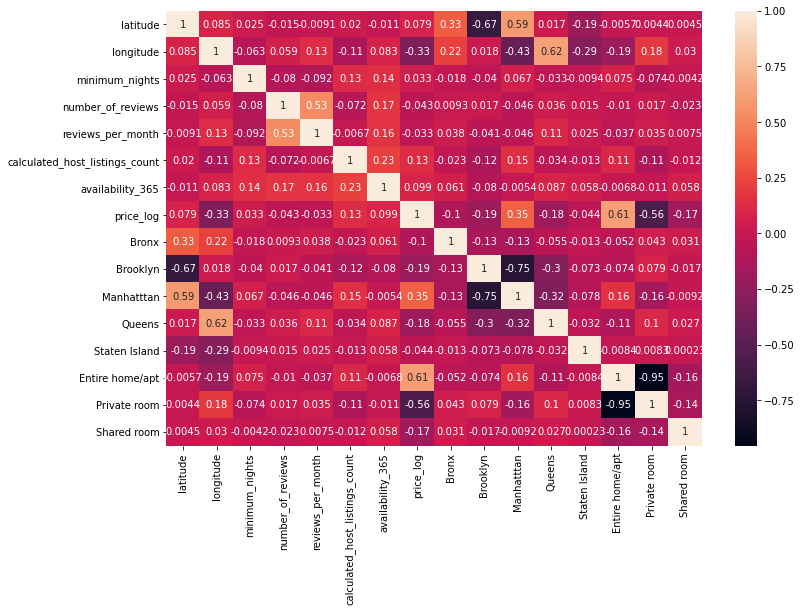

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df_new.corr(method='pearson'),annot=True)

- Moderative Negative correlation: 
- Private room & Price
- Entire home & Price

### Residual Plots - Detect Outliers

- Detect outliers, non-linear data, and detecting data for regression models

### Multicollinearity

- Using Eigen vector values
- If eigenvalues are close to 0, indicating that the predictors are highly intercorrelated and that samll changes in the data values may lead to large changes in the estimates of the coefficients

In [29]:
corr = df_new.corr(method='pearson')

In [30]:
corr_m, V= np.linalg.eig(corr)
corr_m

array([ 3.04490749e+00,  2.22543468e+00,  1.77347910e+00,  1.51213342e+00,
        2.05767751e-01,  2.74206643e-01,  3.89261956e-01,  4.73130482e-01,
        1.29818685e+00,  7.10650605e-01,  8.76117524e-01,  1.11664463e+00,
        1.01680158e+00,  1.08327729e+00, -1.73476405e-13,  2.62390970e-13])

## Scaling

In [31]:
scaler = StandardScaler()
numeric_col_new = numeric_col_new.drop(['price_log'],axis=1)
numeric_col_new_1 = pd.DataFrame(scaler.fit_transform(numeric_col_new),columns=numeric_col_new.columns)

In [32]:
y = df_new['price_log']

In [33]:
X = pd.concat([numeric_col_new_1,dummy],axis=1)

In [36]:
X = X.rename({'neighbourhood_group_Bronx':'Bronx', 
                       'neighbourhood_group_Brooklyn':'Brooklyn','neighbourhood_group_Manhattan':'Manhatttan'
                       ,'neighbourhood_group_Queens':'Queens','neighbourhood_group_Staten Island':'Staten Island',
                       'room_type_Entire home/apt':'Entire home/apt','room_type_Private room':'Private room',
                        'room_type_Shared room':'Shared room'},axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## Model Building

In [55]:
lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [73]:
ridge_cv = RidgeCV(alphas=[1e-3,1e-2,1e-1,1]).fit(X_train,y_train)
ridge = Ridge(alpha = ridge_cv.alpha_, normalize=True)
ridge.fit(X_train,y_train)
r_pred = ridge.predict(X_test)

In [74]:
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000, normalize=False)
lasso_cv.fit(X_train,y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(X_train,y_train)
la_pred = lasso.predict(X_test)

In [76]:
elastic = ElasticNet(alpha=0.01,normalize=False)
elastic.fit(X_train, y_train)
e_pred = elastic.predict(X_test)

- MAE: shows the difference between predictions and actual values
- RMSE: shows how accurately the model predicts the response
- R^2: will be calculated to find the goodness of fit measure

In [77]:
print('LR MAE: %f'% mean_absolute_error(y_test,lr_pred))
print('LR RMSE: %f'% np.sqrt(mean_squared_error(y_test,lr_pred)))
print('LR R^2: %f'% r2_score(y_test,lr_pred))
print('Ridge MAE: %f'% mean_absolute_error(y_test,r_pred))
print('Ridge RMSE: %f'% np.sqrt(mean_squared_error(y_test,r_pred)))
print('Ridge R^2: %f'% r2_score(y_test,r_pred))
print('Lasso MAE: %f'% mean_absolute_error(y_test,la_pred))
print('Lasso RMSE: %f'% np.sqrt(mean_squared_error(y_test,la_pred)))
print('Lasso R^2: %f'% r2_score(y_test,la_pred))
print('ElasticNet MAE: %f'% mean_absolute_error(y_test,e_pred))
print('ElasticNet RMSE: %f'% np.sqrt(mean_squared_error(y_test,e_pred)))
print('ElasticNet R^2: %f'% r2_score(y_test,e_pred))

LR MAE: 0.355496
LR RMSE: 0.489528
LR R^2: 0.494458
Ridge MAE: 0.377869
Ridge RMSE: 0.516758
Ridge R^2: 0.436654
Lasso MAE: 0.355408
Lasso RMSE: 0.489448
Lasso R^2: 0.494624
ElasticNet MAE: 0.358461
ElasticNet RMSE: 0.494350
ElasticNet R^2: 0.484450


Text(0.5, 1.0, 'Elastic Net')

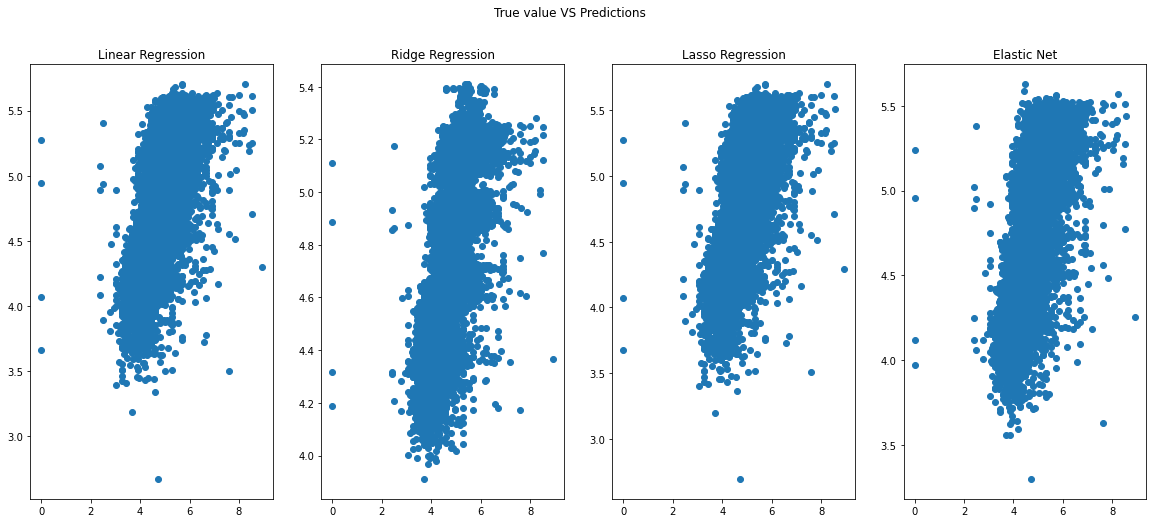

In [88]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,8))
fig.suptitle('True value VS Predictions')

ax1.scatter(y_test, lr_pred)
ax1.set_title('Linear Regression')
ax2.scatter(y_test, r_pred)
ax2.set_title('Ridge Regression')
ax3.scatter(y_test, la_pred)
ax3.set_title('Lasso Regression')
ax4.scatter(y_test, e_pred)
ax4.set_title('Elastic Net')

### No Parameter tuning

In [96]:
n_folds = 5
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(numeric_col_new_1)
    return cross_val_score(model,X_train,y_train, scoring='neg_mean_squared_error',cv=kf)

In [97]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet]:
    cv_res = rmse_cv(Model())
    print('{}: {:5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.251351 +/- 0.003343
Ridge: 0.251351 +/- 0.003344
Lasso: 0.487561 +/- 0.006548
ElasticNet: 0.487561 +/- 0.006548


### Ridge Regression - Hyperparameter Optimization

In [100]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 10, 15, 30, 50, 80]
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [101]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

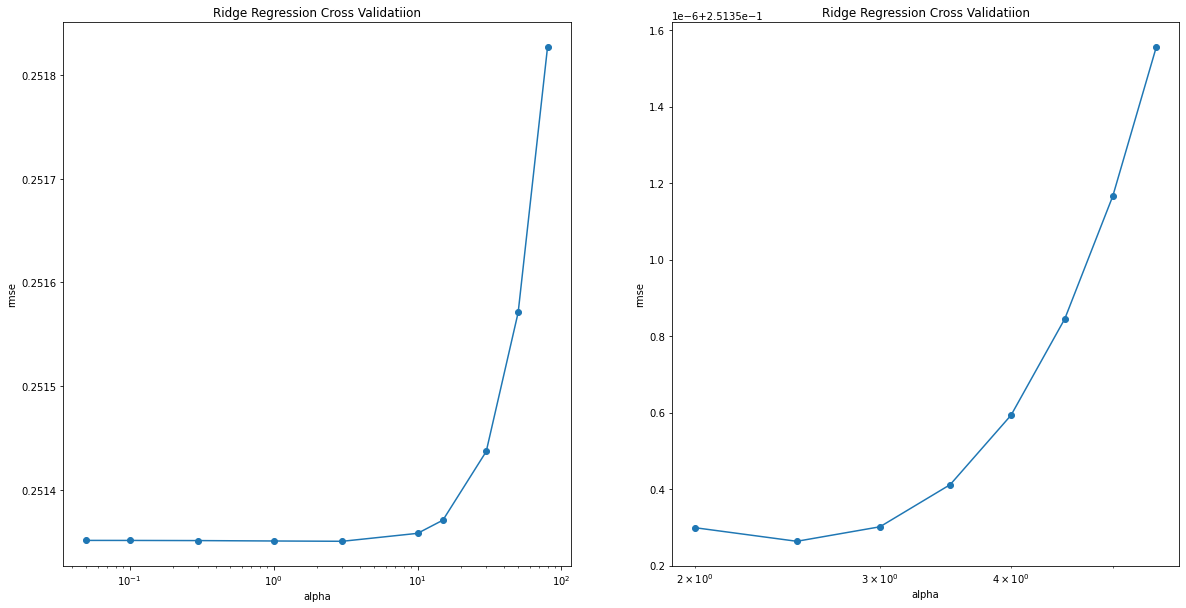

In [107]:
cv_ridge1 = pd.Series(cv_ridge1, index=alphas1)
cv_ridge2 = pd.Series(cv_ridge2, index=alphas2)

fig, axes = plt.subplots(1,2, figsize=(20, 10))
cv_ridge1.plot(title = 'Ridge Regression Cross Validatiion', style='-o', ax=axes[0])
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('rmse')
axes[0].set_xscale('log')

cv_ridge2.plot(title = 'Ridge Regression Cross Validatiion', style='-o', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('rmse')
axes[1].set_xscale('log')

### Best Ridge Regression model

In [125]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_cv_best = -rmse_cv(Ridge(alpha=best_alpha))
RR = Ridge(alpha = best_alpha)
RR.fit(X_train, y_train)
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],'CV error': RR_cv_best.mean(),
                             'CV std': RR_cv_best.std(),
                             'training error': [mean_squared_error(y_train,y_train_RR)],
                             'test error': [mean_squared_error(y_test, y_test_RR)],
                             'training_r2_score': [r2_score(y_train, y_train_RR)],
                             'test_r2_score': [r2_score(y_test,y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.25135,0.003344,0.250702,0.239614,0.485768,0.494508


### Lasso Regression - Hyperparameter Tuning

In [111]:
alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.4, 1]
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

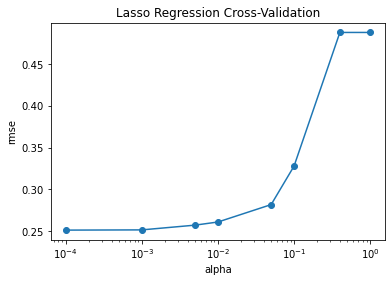

In [114]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = 'Lasso Regression Cross-Validation', style='-o')
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.xscale('log')

### Best Lasso Regression Model

In [128]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
Lasso_cv_best = -rmse_cv(Lasso(alpha=best_alpha))
Lass = Lasso(alpha=best_alpha)
Lass.fit(X_train, y_train)
y_train_lass = Lass.predict(X_train)
y_test_lass = Lass.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['Lasso Regression'],'CV error':Lasso_cv_best.mean(),
                             'CV std': Lasso_cv_best.std(),
                             'training error': [mean_squared_error(y_train, y_train_lass)],
                             'test error': [mean_squared_error(y_test, y_test_lass)],
                             'training_r2_score': [r2_score(y_train, y_train_lass)],
                             'test_r2_score': [r2_score(y_test, y_test_lass)]})
lasso_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Lasso Regression,0.25135,0.003349,0.250704,0.239596,0.485764,0.494546


# Summary

In [129]:
pd.concat([ridge_results, lasso_results],axis=0,ignore_index=True)

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.25135,0.003344,0.250702,0.239614,0.485768,0.494508
1,Lasso Regression,0.25135,0.003349,0.250704,0.239596,0.485764,0.494546
